## Stochastic Gradient Descent: How Choice Affects Convergence

В этой работе сравнивается сходимость и точность по метрике accuracy для SGD с применением батчирования и различных видов шаффлинга(Independent Choice, Random Reshuffling, Cyclic) на датасетах mushrooms, a9a, w8a.

В качестве функции потерь используется логистическая регрессия.

Реализованы три метода:
- **SGD-IC** (Independent Choices) — случайная выборка с заменой  
- **SGD-RR** (Random Reshuffle) — случайное перемешивание данных каждый эпох  
- **SGD-Cyclic** — последовательный обход данных 

В качестве функции потерь используется логистическая регрессия.

## Логистическая регрессия: основные формулы

Логистическая регрессия решает **бинарную задачу классификации**, предсказывая вероятность принадлежности объекта к классу 1:

$P(y=1 \mid x; w) = h_w(x) = \sigma(w^T x)$
где:

$y ∈ {0, 1}$ — целевая метка

$w ∈ ℝ^n$ — вектор весов

$x ∈ ℝ^n$ — вектор признаков

## Сигмоидная функция

$\sigma(z) = \frac{1}{1 + e^{-z}}$

## Функция потерь (Log Loss)
Минимизирует расхождение между предсказаниями и истинными метками:

$J(w) = -\frac{1}{m} \sum_{i=1}^m \left[ y_i \log(h_w(x_i)) + (1 - y_i) \log(1 - h_w(x_i)) \right]$
где m — количество объектов.

## Градиент функции потерь

$\frac{\partial J}{\partial w_j} = \frac{1}{m} \sum_{i=1}^m (h_w(x_i) - y_i) x_{ij}$
В матричной форме:

$\nabla J(w) = \frac{1}{m} X^T (\sigma(Xw) - y)$
где:

$X ∈ ℝ^{m×n}$ — матрица признаков

$y ∈ ℝ^m$ — вектор меток

### Краткое описание датасетов

#### **Mushrooms**
- **Задача**: Бинарная классификация (съедобный/ядовитый гриб)  
- **Примеры**: 8,124  
- **Признаки**: 22 
- **Особенности**:  
  - Идеально сбалансированные классы (50/50)

#### **a9a** (Adult Income)
- **Задача**: Предсказание дохода (>50K/$ ≤50K)  
- **Примеры**: ~48,842 (train) + ~16,281 (test)  
- **Признаки**: 123
- **Особенности**:  
  - Дисбаланс классов (~24% >50K)  
  - Реальные демографические данные из U.S. Census

#### **w8a** (Web Page Classification)
- **Задача**: Классификация веб-страниц (тематика)  
- **Примеры**: 49,749 (train) + 14,951 (test)  
- **Признаки**: 300 
- **Особенности**:  
  - Сильно разреженные данные (99.3% нулей)  
  - Дисбаланс классов (~3% положительных примеров)

**Источники**: UCI Machine Learning Repository, LIBSVM datasets

**Датасет mushrooms**

In [89]:
dataset = "mushrooms.txt"

data = load_svmlight_file(dataset)
X, y = data[0].toarray(), data[1]
n, d = X.shape

y[y == 2] = -1

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

n_train, d_train = X_train.shape
n_test = X_test.shape[0]
A = X_train
b = y_train
gamma = 0.1 
max_epochs = 200 
batch_size = 32

In [90]:
def log_loss(A, y, x):
    yAx = y * (A @ x)
    return np.log(1 + np.exp(-yAx))

In [91]:
def grad_full(A, y, x):
    yAx = y * (A @ x)
    exp_term = np.exp(-yAx)
    sigmoid = exp_term / (1 + exp_term)
    return -(sigmoid * y) @ A / A.shape[0]

In [92]:
def sgd(batch_size, shuffling_method):
    x_k = np.zeros(d_train, dtype=np.float64)
    
    history = [0]
    sgd_errors = [LA.norm(grad_full(A, b, x_k))**2]
    accuracy = [0.5]
    
    stop = False
    converged_epochs = 0
    
    for epoch in range(1, max_epochs+1):
        if stop: break
        
        if shuffling_method == 'IC':
            indices = np.random.choice(n_train, n_train, replace=True)
        elif shuffling_method == 'RR':
            indices = np.random.permutation(n_train)
        else:
            indices = np.arange(n_train)
        
        for batch_start in range(0, n_train, batch_size):
            batch_indices = indices[batch_start:batch_start+batch_size]
            gradient = grad_full(A[batch_indices], b[batch_indices], x_k)
            x_k -= gamma / np.sqrt(epoch) * gradient

        sgd_errors.append(LA.norm(grad_full(A, b, x_k))**2)
        history.append(epoch)

        preds = X_test @ x_k
        current_acc = np.mean(np.sign(preds) == y_test)
        accuracy.append(current_acc)

        if epoch >= 5 and np.allclose(accuracy[-5:], [current_acc]*5, atol=1e-5):
            stop = True

    return sgd_errors, history, accuracy

In [93]:
print("Start sgd_ic")
sgd_errors_ic, history_ic, accuracy_ic = sgd(batch_size, 'IC')

print("Start sgd_rr")
sgd_errors_rr, history_rr, accuracy_rr = sgd(batch_size, 'RR')

print("Start sgd_cyc")
sgd_errors_cyc, history_cyc, accuracy_cyc = sgd(batch_size, 'Cyclic')

Start sgd_ic
Start sgd_rr
Start sgd_cyc


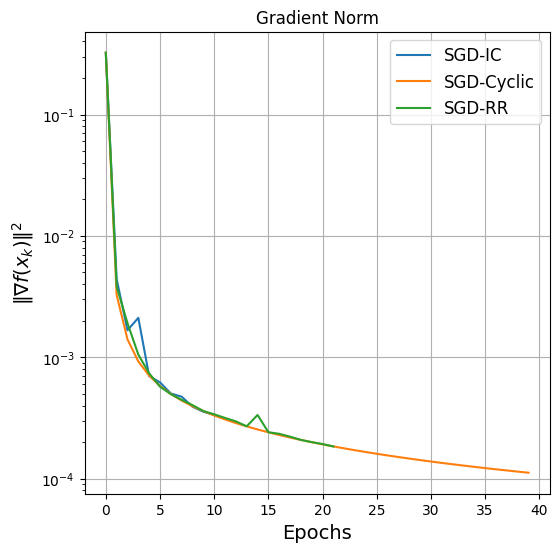

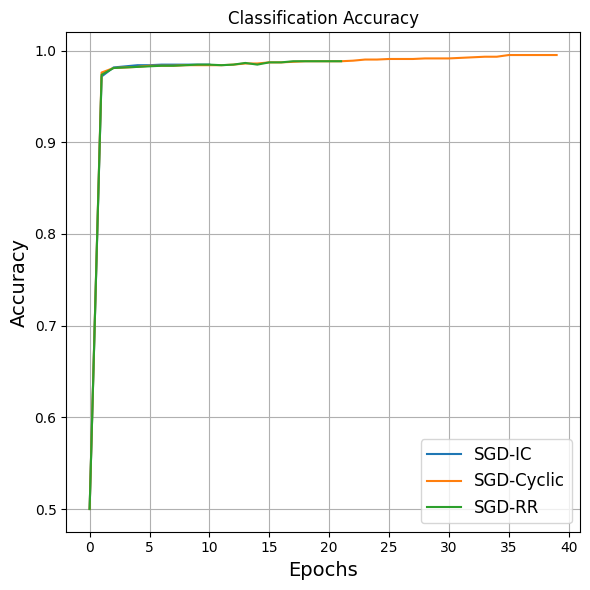

In [94]:
plt.figure(figsize=(6, 6))
plt.title('Gradient Norm')
plt.plot(history_ic, sgd_errors_ic, label='SGD-IC')
plt.plot(history_cyc, sgd_errors_cyc, label='SGD-Cyclic')
plt.plot(history_rr, sgd_errors_rr, label='SGD-RR')
plt.yscale('log')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel(r'$\|\nabla f(x_k)\|^2 $', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

plt.figure(figsize=(6, 6))
plt.title('Classification Accuracy')
plt.plot(history_ic, accuracy_ic, label='SGD-IC')
plt.plot(history_cyc, accuracy_cyc, label='SGD-Cyclic')
plt.plot(history_rr, accuracy_rr, label='SGD-RR')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

plt.tight_layout()
plt.show()

**Датасет a9a**

In [95]:
dataset = "a9a.txt"

data = load_svmlight_file(dataset)
X, y = data[0].toarray(), data[1]
n, d = X.shape

y = np.where(y == 1, 1, -1)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

n_train, d_train = X_train.shape
n_test = X_test.shape[0]
A = X_train
b = y_train
gamma = 0.05
max_epochs = 200
batch_size = 64

In [96]:
print("Start sgd_ic")
sgd_errors_ic, history_ic, accuracy_ic = sgd(batch_size, 'IC')

print("Start sgd_rr")
sgd_errors_rr, history_rr, accuracy_rr = sgd(batch_size, 'RR')

print("Start sgd_cyc")
sgd_errors_cyc, history_cyc, accuracy_cyc = sgd(batch_size, 'Cyclic')

Start sgd_ic
Start sgd_rr
Start sgd_cyc


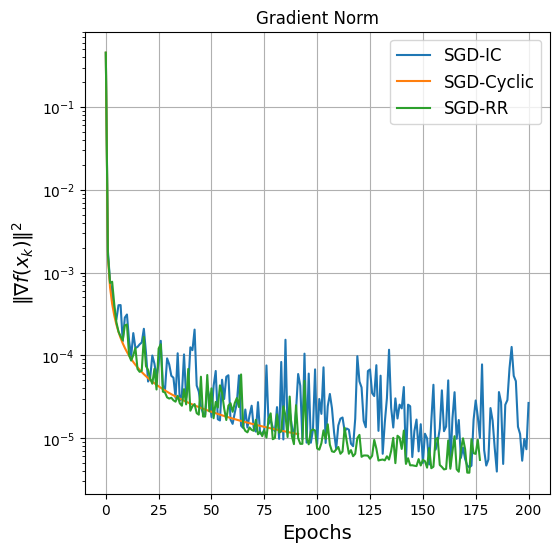

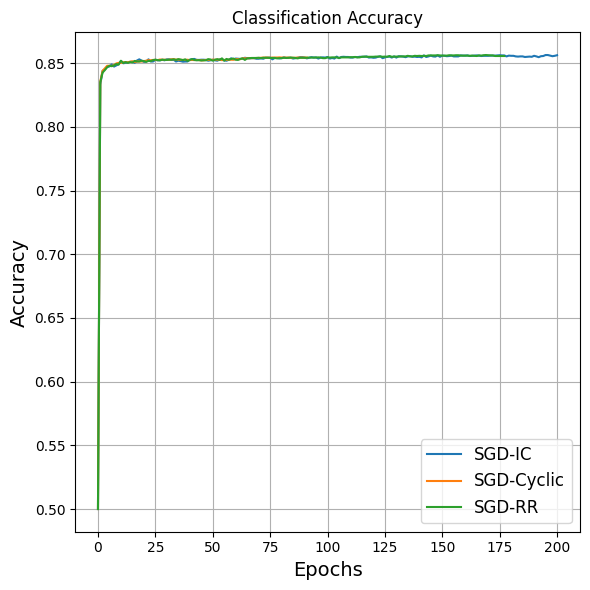

In [97]:
plt.figure(figsize=(6, 6))
plt.title('Gradient Norm')
plt.plot(history_ic, sgd_errors_ic, label='SGD-IC')
plt.plot(history_cyc, sgd_errors_cyc, label='SGD-Cyclic')
plt.plot(history_rr, sgd_errors_rr, label='SGD-RR')
plt.yscale('log')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel(r'$\|\nabla f(x_k)\|^2 $', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

plt.figure(figsize=(6, 6))
plt.title('Classification Accuracy')
plt.plot(history_ic, accuracy_ic, label='SGD-IC')
plt.plot(history_cyc, accuracy_cyc, label='SGD-Cyclic')
plt.plot(history_rr, accuracy_rr, label='SGD-RR')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

plt.tight_layout()
plt.show()

**Датасет w8a**

In [98]:
dataset = "w8a.txt"

data = load_svmlight_file(dataset)
X, y = data[0].toarray(), data[1]
n, d = X.shape

y = np.where(y == 1, 1, -1)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

n_train, d_train = X_train.shape
n_test = X_test.shape[0]
A = X_train
b = y_train
gamma = 0.1     
max_epochs = 200  
batch_size = 32    


In [99]:
print("Start sgd_ic")
sgd_errors_ic, history_ic, accuracy_ic = sgd(batch_size, 'IC')

print("Start sgd_rr")
sgd_errors_rr, history_rr, accuracy_rr = sgd(batch_size, 'RR')

print("Start sgd_cyc")
sgd_errors_cyc, history_cyc, accuracy_cyc = sgd(batch_size, 'Cyclic')

Start sgd_ic
Start sgd_rr
Start sgd_cyc


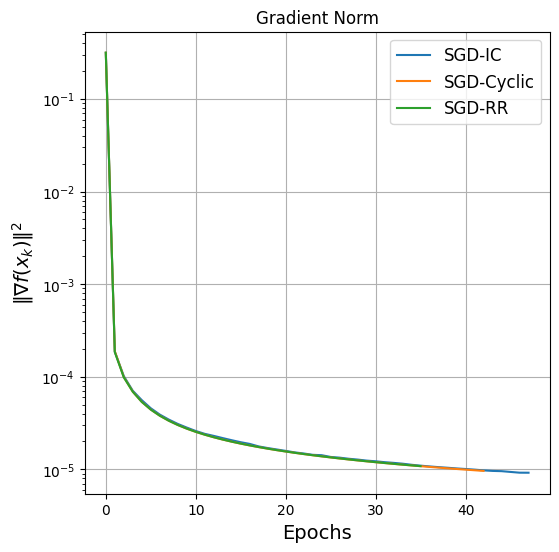

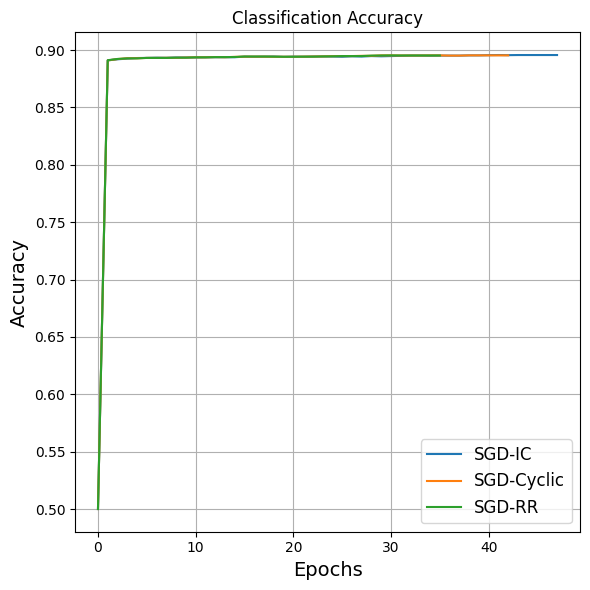

In [100]:
plt.figure(figsize=(6, 6))
plt.title('Gradient Norm')
plt.plot(history_ic, sgd_errors_ic, label='SGD-IC')
plt.plot(history_cyc, sgd_errors_cyc, label='SGD-Cyclic')
plt.plot(history_rr, sgd_errors_rr, label='SGD-RR')
plt.yscale('log')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel(r'$\|\nabla f(x_k)\|^2 $', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

plt.figure(figsize=(6, 6))
plt.title('Classification Accuracy')
plt.plot(history_ic, accuracy_ic, label='SGD-IC')
plt.plot(history_cyc, accuracy_cyc, label='SGD-Cyclic')
plt.plot(history_rr, accuracy_rr, label='SGD-RR')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

plt.tight_layout()
plt.show()